# 一.数据处理

In [1]:
#coding=utf-8
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from dateutil import parser 
pd.options.display.latex.repr = True

In [2]:
########降雨数据处理#######
rain1 = pd.read_table('P8901.DAT',header=None,parse_dates = [0,1,2,3],sep='\s+')
rain2 = pd.read_table('P8902.DAT',header=None,parse_dates = [0,1,2,3],sep='\s+')
rain3 = pd.read_table('P8903.DAT',header=None,parse_dates = [0,1,2,3],sep='\s+')
rain = df(rain2.iloc[:,0:4])
rain[4] = (rain1[4]+rain2[4]+rain3[4])/3
rain = rain[rain[4]>=0]
rain_data = df([])
for i in range(len(rain)):
    time = '1989-'+str(rain.iloc[i,0])+'-'+str(rain.iloc[i,1])+' '
    rain_data = rain_data.append([[parser.parse(time+str(rain.iloc[i,2])+':00'),
                                   parser.parse(time+str(rain.iloc[i,3])+':00'),rain.iloc[i,4]]])
rain_data.head()
rain_data.columns = ['time0','time1','rain']
rain_data = rain_data.reset_index(drop=True)
rain_data.head() ##降雨数据

,time0,time1,rain
0,1989-04-01 02:00:00,1989-04-01 08:00:00,0.00
1,1989-04-01 08:00:00,1989-04-01 14:00:00,0.00
2,1989-04-01 14:00:00,1989-04-01 20:00:00,0.00
3,1989-04-01 20:00:00,1989-04-01 02:00:00,0.05
4,1989-04-02 02:00:00,1989-04-02 08:00:00,1.00


In [3]:
#########径流数据处理########
flow = pd.read_table('Q89.DAT',header=None,parse_dates = [0,1,2],sep='\s+')
flow = flow[flow[3]>=0]
flow_data = df([])
for i in range(len(flow)):
    flow_data = flow_data.append([[parser.parse('1989-'+str(flow.iloc[i,0])+'-'+str(flow.iloc[i,1])+' '
                                                +str(flow.iloc[i,2])+':00'),flow.iloc[i,3]]])
flow_data.columns = ['time','flow']
flow_data = flow_data.reset_index(drop=True)
flow_data.head() ##径流数据

,time,flow
0,1989-04-01 02:00:00,11.60
1,1989-04-01 08:00:00,11.60
2,1989-04-01 14:00:00,10.39
3,1989-04-01 20:00:00,9.18
4,1989-04-02 02:00:00,7.96


In [4]:
import math
qqq = 411.8996870315166
fade_water = []
fade_water.append(qqq)
while qqq > 11:
    qqq = qqq * pow(math.e, -6/48)
    fade_water.append(qqq)
#fade_water #退水曲线

In [6]:
day_eva = df([0.71,0.68,0.93,1.57,2.29,2.65,3.41,2.76,2.44,1.75,1.21,0.87],
            columns=['sunny'])
day_eva['rainy'] = [0.60,0.31,0.55,0.97,1.49,1.71,2.34,2.45,1.03,0.77,0.60,0.36]
kc = df([1.0,1.0,1.0,1.36,1.09,0.90,1.68,1.47,0.78,1.0,1.0,1.0], columns=['kc'])
kc.head() ##kc系数计算

,kc
0,1.00
1,1.00
2,1.00
3,1.36
4,1.09


In [7]:
data_rain = rain_data.loc[0, 'rain']
for i in range(1, len(flow_data)):
    month = rain_data.loc[i, 'time0'].month
    if i%4 == 0:
        if data_rain >=3:
            rain_data.loc[i-4:i, 'eva'] = day_eva.loc[month-1, 'rainy']/4
        else:
            rain_data.loc[i-4:i, 'eva'] = day_eva.loc[month-1, 'sunny']/4
        rain_data.loc[i-4:i, 'kc'] = kc.loc[month-1, 'kc']
        data_rain = 0
    data_rain +=  rain_data.loc[i, 'rain']
rain_data.head() # 降雨 蒸散发 kc系数

,time0,time1,rain,eva,kc
0,1989-04-01 02:00:00,1989-04-01 08:00:00,0.00,0.3925,1.36
1,1989-04-01 08:00:00,1989-04-01 14:00:00,0.00,0.3925,1.36
2,1989-04-01 14:00:00,1989-04-01 20:00:00,0.00,0.3925,1.36
3,1989-04-01 20:00:00,1989-04-01 02:00:00,0.05,0.3925,1.36
4,1989-04-02 02:00:00,1989-04-02 08:00:00,1.00,0.2425,1.36


# 三.降雨径流曲线

In [8]:
W = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
PE = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]
WM = 150
B = 1.5

In [9]:
#绘制制图数据
q = df([])
for i in range(len(W)):
    W0 = W[i]
    f = []
    for j in range(len(PE)):
        p = PE[j]
        WMM=WM*(1+B)
        A=WMM*(1-(1-W0/WM)**(1/(1+B)))
        if (p+A)/WMM >1 :
            if p-(WM-W0) < 0:
                f.append(0)
            else:
                f.append(p-(WM-W0))
        else:
            f.append(p-(WM-W0)+WM*(1-(p+A)/WMM)**(1+B))
    q[i] = f
q.columns = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
#q = q.reset_index()
q['PE'] = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]
q.index=q['PE']
q = q.drop(columns=['PE'])
q.head()

,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150
PE,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,1.421085e-14,2.842171e-14,0.000000,0.000000,-1.421085e-14,-7.105427e-15,0.000000,7.105427e-15,-3.552714e-15,-1.421085e-14,-3.552714e-15,0.0
10,0.199108,0.601861,1.016217,1.443441,1.885057e+00,2.342927e+00,2.819368,3.317332,3.840679e+00,4.394638e+00,4.986617,5.627765e+00,6.336414e+00,7.147195e+00,8.145368e+00,10.0
20,0.792841,1.592789,2.415614,3.263798,4.140330e+00,5.048859e+00,5.993924,6.981298,8.018528e+00,9.115818e+00,10.287604,1.155557e+01,1.295527e+01,1.455360e+01,1.651407e+01,20.0
30,1.775754,2.967262,4.192582,5.455368,6.760011e+00,8.111871e+00,9.517609,10.985689,1.252716e+01,1.415694e+01,15.896099,1.777622e+01,1.984891e+01,2.221083e+01,2.509634e+01,30.0
40,3.142327,4.719676,6.341428,8.012357,9.738197e+00,1.152594e+01,13.384259,15.324177,1.736006e+01,1.951126e+01,21.805086,2.428233e+01,2.700945e+01,3.011026e+01,3.388194e+01,40.0


In [10]:
q.to_csv('r_f.csv')

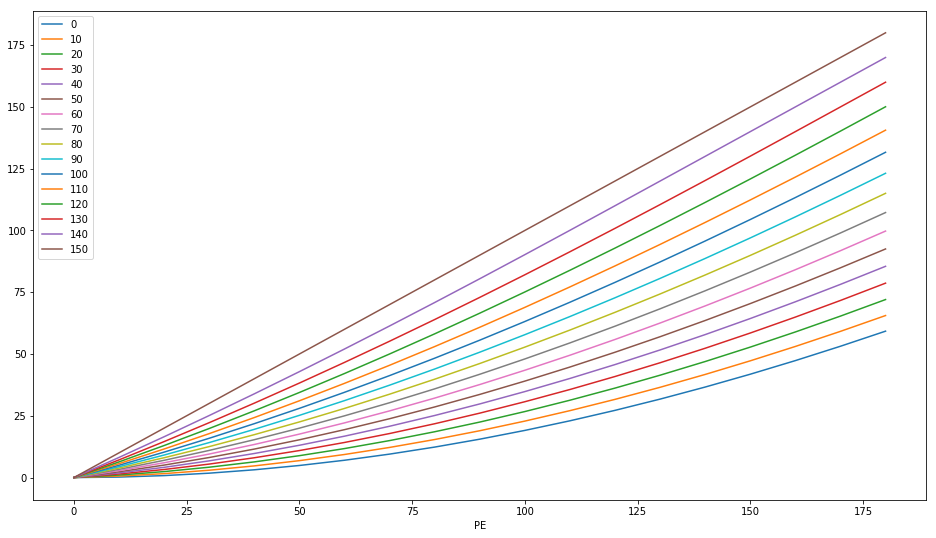

In [12]:
#绘图模块
import matplotlib.pyplot as plt
# a scatter plot comparing num_children and num_pets
q.plot(figsize=(16,9))
plt.show()


# 四. 建立产流模型1

In [13]:
class Soil_Object:
    #产量参数
    _wm = 150
    _um = 30
    _lm = 80
    _dm = 40
    _b = 1.5
    _c = 0.167
    #蒸发参数
    _sm = 9
    _ex = 1.9
    _kg = 0.109
    _ki = 0.156
    _s = 0
    _ri = 0
    _rg = 0
    _rs = 0

    p = 0
    ep, r = 0, 0
    eu, el, ed = 0, 0, 0
    fr = 0

    def __init__(self, wu=0, wl=1.3, wd=40, s=0):  # 初始化土壤数值
        self.wu, self.wl, self.wd, self._w, self._s0 = wu, wl, wd, wu + wl + wd, s

    def next(self, p, em, kc=1.0):  # 下一个node的参数
        self.p = p
        # self.em = em
        self.ep = em * kc
        e, eu, el, ed = self.__cal_eva(p=self.p, ep=self.ep)  # 计算蒸发
        #self._e = e
        if e < self.ep:
            self.__set_soil_eva(eu=eu, el=el, ed=ed, p=p)  # 更新蒸发量
            return [0,0,0]
        else:
            p0 = self.__set_p0(p=p, e=e)  # 计算??水变化量
            r = self.__cal_flow(w0=self._w, pe=p0)  # 计算产流
            self._w, self.wu, self.wl, self.wd = self.__recharge(p0, r)
            self.r = r
            
            s0 = self._s0
            s, self._s0, ra = self.__divide_flow(s0, p0, r)
            
            #print(r)
            self.__set_divide(s, ra)
            #a = self.get_r()
            return ra
            #return [rs, ri, rg]
 
    def __recharge(self, p0, r):
        um, lm, dm = self._um, self._lm, self._dm
        wu, wl, wd = self.wu, self.wl, self.wd
        p = (p0 - r)
        if p + wu <= um:
            wu += p
        else:
            p1 = p + wu - um
            wu = um
            if p1 + wl <= lm:
                wl += p1
            else:
                p2 = p1 + wl - lm
                wl = lm
                if p2 + wd <= dm:
                    wd += p2
                else:
                    wd = dm

        w = wu + wl + wd
        return w, wu, wl, wd

    ####计算产流量######
    def __cal_flow(self, w0, pe):
        if pe < 0:
            return 0
        wm, b = self._wm, self._b
        wmm = wm * (1 + b)
        a = wmm * (1 - (1 - w0 / wm) ** (1 / (1 + b)))
        if a + pe < wmm:
            r = pe - (wm - w0) + wm * (1 - (pe + a) / wmm) ** (1 + b)
        else:
            r = pe - wm + w0
        # print(1-(pe+a)/wmm)
        return r

    def __divide_flow(self, s0, pe, r):   #三水源划分
        sm, ex, fr0 = self._sm, self._ex,self.fr
        ms = sm * (1 + ex)
        if pe < 0:
            self.fr = fr = 0
        else:
            self.fr = fr = r/pe
        if fr*fr0 == 0:
            ratio = 1
        else:
            ratio = fr/fr0
        if fr == 0:
            rs = 0
            s = s0
        else:
            au = ms * (1 - (1 -  s0  / sm) ** (1 / (1 + ex)))
            if au + pe < ms:
                rs = fr * (pe + s0 * ratio - sm + sm * (1 - (pe + au)/ ms )**(1 + ex))
            else:
                rs = fr * (pe + s0 * ratio - sm)
            if fr == 0:
                s = s0
            else:        
                s = s0 * ratio + (r - rs)/fr
        ri = self._ki * s * fr
        rg = self._kg * s * fr
        s1 = s * (1 - self._ki - self._kg)
        #print(s, s1, rs, ri, rg)
        return s, s1, [rs, ri, rg]

    def __cal_eva(self, p, ep=ep):
        c = self._c

        # wu/wl/wd 上、中、下层土壤水量
        wu, wl = self.wu, self.wl

        if p + self.wu >= ep:
            eu = ep
            el, ed = 0, 0
            # rest_water = wu + p - ep  #土壤水计算
            # self.__recharge(r = rest_water)
        else:
            lm = self._lm  # 下层张力水最大含量
            eu = p + wu
            # self.wu = 0
            # p1 = p-
            if wl >= c * lm:
                el = (ep - eu) * wl / lm
                ed = 0
            elif wl >= c * (ep - eu):
                el = c * (ep - eu)
                ed = 0
            else:
                el = wl
                ed = c * (ep - eu) - wl
        e = eu + el + ed
        return e, eu, el, ed

    def __set_p0(self, p, e):
        p0 = self._p0 = p - e
        return p0

    def __set_divide(self, s, r):
        self._s = 0 if s is None else s
        self._rs = r[0]
        self._ri = r[1]
        self._rg = r[2]

    def __set_soil_eva(self, eu, el, ed, p):  # 更新蒸发后土壤含水量
        self.wu -= (eu - p)
        self.wl -= el
        self.wd -= ed
        self._w -= eu + el + ed

    def get_fi(self):
        return self._ri

    def get_fg(self):
        return self._rg

    def get_s(self):
        return self._s

    def get_p0(self):
        return self._p0

    def get_e(self):
        return self._e

    def get_w(self):
        return self._w
    
    def get_r(self):
        return [self._rs, self._ri, self._rg]



# 五.汇流计算（产流模型2）

In [14]:
#地表水
import scipy.signal
import numpy as np

uh = np.array([0,12.4,102.4,51.9,39.7,33.5,24.4,18.8,13.7,9.4,6.3,3.4,1.7,0])

def conv(rs, uh): #卷积运算
    m = []
    u = np.pad(uh,(0,len(rs)), 'constant')
    for i in range(len(rs)):
        a = 0
        for j in range(0, i+1):
            a += rs[j]*u[i-j]
        m.append(a)
    return m

In [15]:
cp = df(conv(rain_data.loc[:, 'rain']/10, uh))
cp['flow'] = flow_data['flow']
cp.head()

,0,flow
0,0.000,11.60
1,0.000,11.60
2,0.000,10.39
3,0.000,9.18
4,0.062,7.96


In [16]:
#壤中流与地下径流
qi0 = (0.975/(0.975+0.964))*11.6
qg0 = (0.964/(0.964+0.975))*11.6
U = 686/(3.6*6)
ci = 0.975
cg = 0.964 
qi = lambda qi0, ri: ci * qi0 + (1 - ci) * ri * U
qg = lambda qg0, rg: cg * qg0 + (1 - cg) * rg * U

In [17]:
U

31.759259259259256

# 六.运行模型

In [18]:
wu1 = 30*0.8
wl1 = 80*0.8
wd1 = 40*0.8
s1 = 9*0.8

In [19]:
runoff = []
inter_water = []
ground_water = []
r = []
q_inter = []
q_g = []
qi0 = (0.975/(0.975+0.964))*11.6
qg0 = (0.964/(0.964+0.975))*11.6
soil = Soil_Object(wu1, wl1, wd1, s1)
for i in range(len(rain_data)):
    a = rain_data.iloc[i,2:5]
    r = soil.next(a[0], a[1], a[2])
    #print(x)
    #r = soil.get_r()
    runoff.append(r[0])
    inter_water.append(r[1])
    ground_water.append(r[2])
    #r = soil.get_r()
    #print(r,i)
    q_inter.append(qi0)
    qi0 = qi(qi0, r[1])
    
    q_g.append(qg0)
    qg0 = qg(qg0, r[2])
   # print(r[2])
    #print(ground_water[0])
    #print(soil.get_w())
    #print(soil.get_r())

In [21]:
rc = list(map(lambda x: x[0]+x[1]+x[2], zip(runoff, inter_water, ground_water)))
rc[0:5]

[0.0, 0.0, 0.0, 0.0, 0.49828043948956335]

In [22]:
rw = np.array(runoff)/10
rw = conv(rw ,uh)
rw[0:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

89412号洪峰流量: 412.00900633064134
89412号洪峰时间: 49   1989-04-13 08:00:00
Name: time, dtype: datetime64[ns]
89412号计算径流深: 101.32816201242704


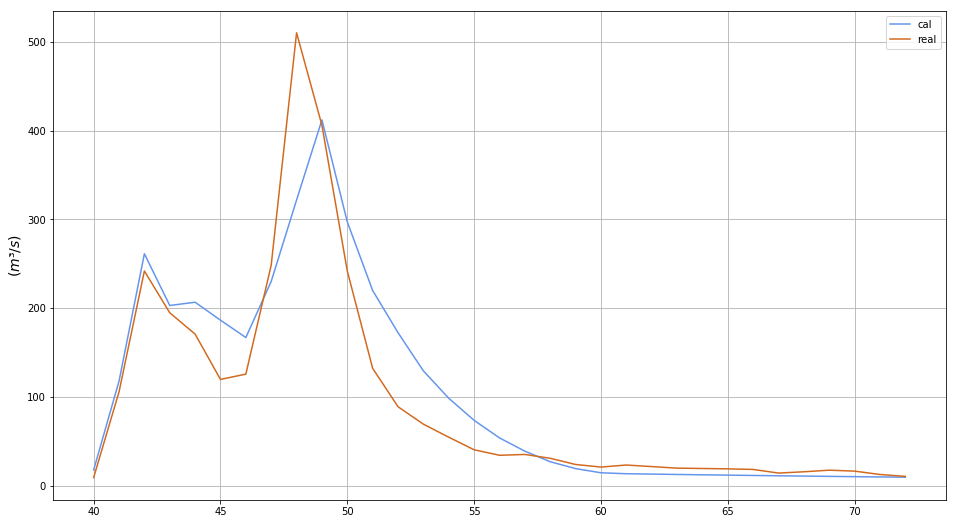

In [35]:
flow = list(map(lambda x: x[0]+x[1]+x[2], zip(rw, q_g, q_inter)))
flow = df(flow,columns=['data'])
flow['time'] = flow_data.loc[:,'time']
h1b = flow.loc[flow.loc[:, 'time']=='1989-04-11 02:00:00' ,'data'].index
h1e = flow.loc[flow.loc[:, 'time']=='1989-04-19 02:00:00' ,'data'].index
print("89412号洪峰流量:" ,flow.loc[h1b.values[0]:h1e.values[0], 'data'].max())
print("89412号洪峰时间:" ,flow.loc[flow.loc[h1b.values[0]:h1e.values[0], 'data'].max() == flow.loc[:, 'data'], 'time'])
print("89412号计算径流深:",sum(rc[h1b.values[0]:h1e.values[0]]))
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(flow.loc[h1b.values[0]:h1e.values[0], 'data'], '-', label='cal', color='#6495ED')
ax.plot(flow_data.loc[h1b.values[0]:h1e.values[0], 'flow'], '-',label='real', color='#D2691E')
ax.set_ylabel('($m³/s$)', fontsize=14)
ax.grid(True)
plt.legend(loc='best')

89419号洪峰流量: 300.2544521967277
89419号洪峰时间: 84   1989-04-22 02:00:00
Name: time, dtype: datetime64[ns]
89419号计算径流深: 74.74081468641157


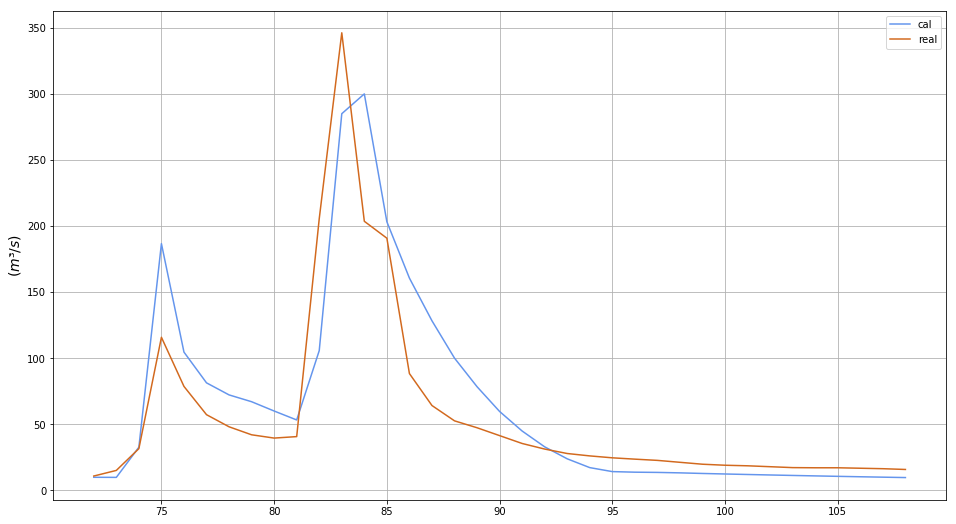

In [36]:
h2b = flow.loc[flow.loc[:, 'time']=='1989-04-19 02:00:00' ,'data'].index
h2e = flow.loc[flow.loc[:, 'time']=='1989-04-28 02:00:00' ,'data'].index
print("89419号洪峰流量:" ,flow.loc[h2b.values[0]:h2e.values[0], 'data'].max())
print("89419号洪峰时间:" ,flow.loc[flow.loc[h2b.values[0]:h2e.values[0], 'data'].max() == flow.loc[:, 'data'], 'time'])
print("89419号计算径流深:",sum(rc[h2b.values[0]:h2e.values[0]]))
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(flow.loc[h2b.values[0]:h2e.values[0], 'data'], '-', label='cal', color='#6495ED')
ax.plot(flow_data.loc[h2b.values[0]:h2e.values[0], 'flow'], '-',label='real', color='#D2691E')
ax.set_ylabel('($m³/s$)', fontsize=14)
ax.grid(True)
plt.legend(loc='best')

89428号洪峰流量: 287.4694237688085
89428号洪峰时间: 114   1989-04-29 14:00:00
Name: time, dtype: datetime64[ns]
89428号计算径流深: 75.8025121390685


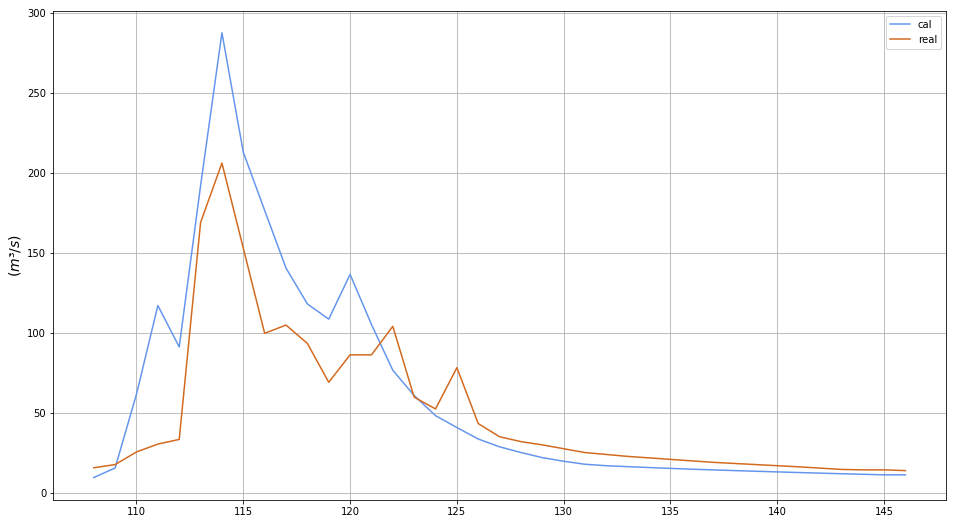

In [34]:
h3b = flow.loc[flow.loc[:, 'time']=='1989-04-28 02:00:00' ,'data'].index
h3e = flow.loc[flow.loc[:, 'time']=='1989-05-7 14:00:00' ,'data'].index
print("89428号洪峰流量:" ,flow.loc[h3b.values[0]:h3e.values[0], 'data'].max())
print("89428号洪峰时间:" ,flow.loc[flow.loc[h3b.values[0]:h3e.values[0], 'data'].max() == flow.loc[:, 'data'], 'time'])
print("89428号计算径流深:",sum(rc[h3b.values[0]:h3e.values[0]]))
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(flow.loc[h3b.values[0]:h3e.values[0], 'data'], '-', label='cal', color='#6495ED')
ax.plot(flow_data.loc[h3b.values[0]:h3e.values[0], 'flow'], '-',label='real', color='#D2691E')
ax.set_ylabel('($m³/s$)', fontsize=14)
ax.grid(True)
plt.legend(loc='best')

In [26]:
h4b = flow.loc[flow.loc[:, 'time']=='1989-05-7 14:00:00' ,'data'].index
h4e = flow.loc[flow.loc[:, 'time']=='1989-05-25 20:00:00' ,'data'].index
print("89507号洪峰流量:" ,flow.loc[h4b.values[0]:h4e.values[0], 'data'].max())
print("89507号洪峰时间:" ,flow.loc[flow.loc[h4b.values[0]:h4e.values[0], 'data'].max() == flow.loc[:, 'data'], 'time'])
print("89507号计算径流深:",sum(rc[h4b.values[0]:h4e.values[0]]))

89507号洪峰流量: 92.27317085687814
89507号洪峰时间: 180   1989-05-16 02:00:00
Name: time, dtype: datetime64[ns]
89507号计算径流深: 50.631722563323365


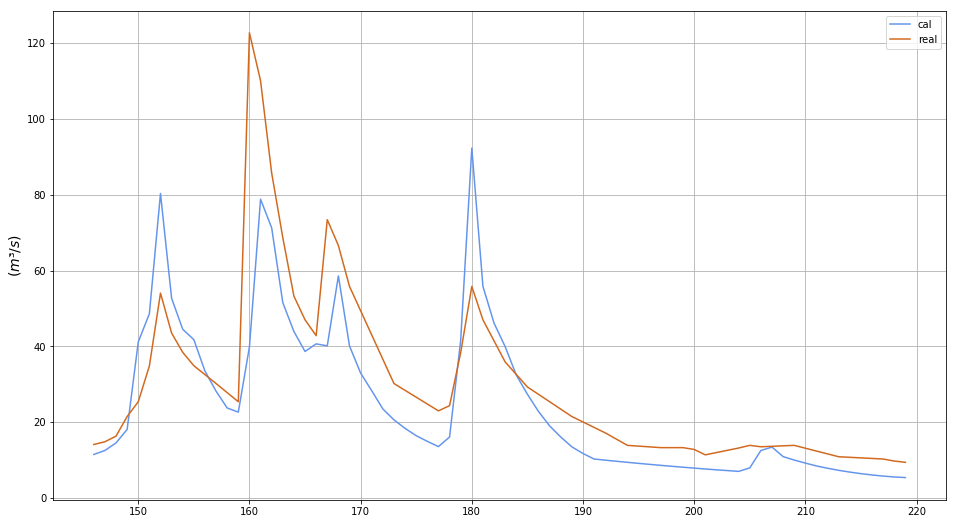

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(flow.loc[h4b.values[0]:h4e.values[0], 'data'], '-', label='cal', color='#6495ED')
ax.plot(flow_data.loc[h4b.values[0]:h4e.values[0], 'flow'], '-',label='real', color='#D2691E')
ax.set_ylabel('($m³/s$)', fontsize=14)
ax.grid(True)
plt.legend(loc='best')

89628号洪峰流量: 292.57456402909315
89628号洪峰时间: 375   1989-07-03 20:00:00
Name: time, dtype: datetime64[ns]
89628号计算径流深: 96.14088086417004


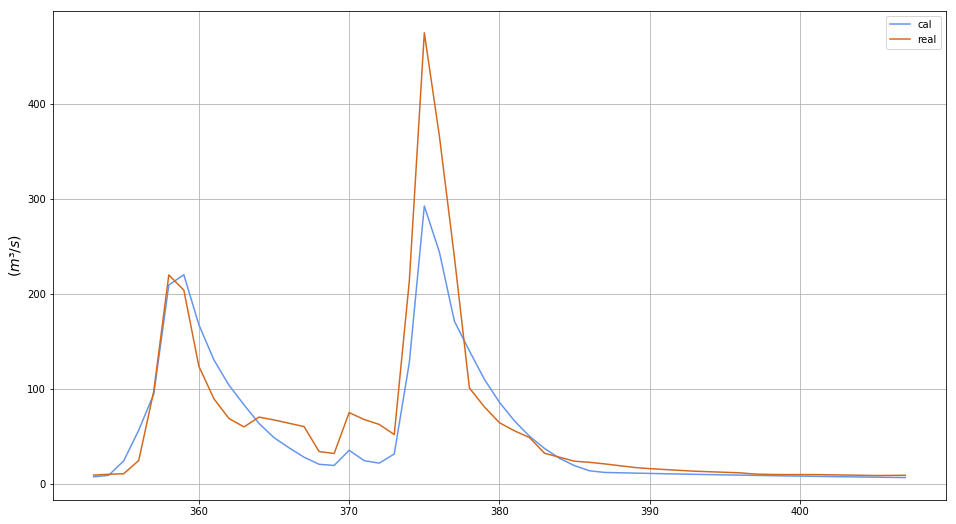

In [38]:
h5b = flow.loc[flow.loc[:, 'time']=='1989-06-28 08:00:00' ,'data'].index
h5e = flow.loc[flow.loc[:, 'time']=='1989-07-11 20:00:00' ,'data'].index
print("89628号洪峰流量:" ,flow.loc[h5b.values[0]:h5e.values[0], 'data'].max())
print("89628号洪峰时间:" ,flow.loc[flow.loc[h5b.values[0]:h5e.values[0], 'data'].max() == flow.loc[:, 'data'], 'time'])
print("89628号计算径流深:",sum(rc[h5b.values[0]:h5e.values[0]]))
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(flow.loc[h5b.values[0]:h5e.values[0], 'data'], '-', label='cal', color='#6495ED')
ax.plot(flow_data.loc[h5b.values[0]:h5e.values[0], 'flow'], '-',label='real', color='#D2691E')
ax.set_ylabel('($m³/s$)', fontsize=14)
ax.grid(True)
plt.legend(loc='best')

# 预报方案检验


In [29]:
def dc(yc, yo):
    yb = np.mean(yo)
    a = list(map(lambda x:(x[0]-x[1])**2, zip(yc,yo)))
    b = list(map(lambda x:(x[0]-yb)**2, zip(yo)))
    return 1- sum(a)/sum(b)

#list(map(lambda x: x[0]+x[1]+x[2], zip(runoff, inter_water, ground_water)))

In [30]:
ho = list(flow_data.loc[h3b.values[0]:h3e.values[0], 'flow'])
hc = list(flow.loc[h3b.values[0]:h3e.values[0], 'data'])
dc(hc, ho)

0.549336297698855

In [31]:
dc(flow_data.loc[:, 'flow'], flow.loc[:, 'data'])

0.7996249395397914

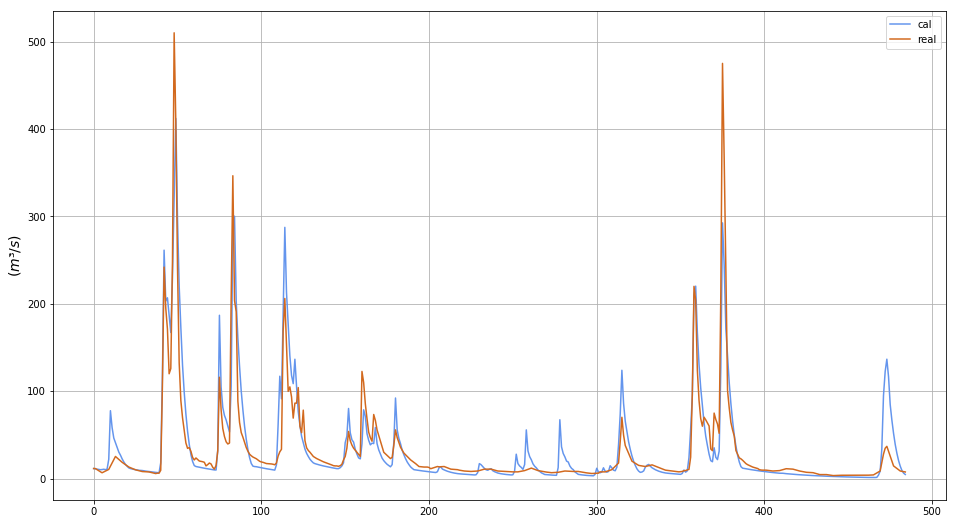

In [32]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(flow.loc[:, 'data'], '-', label='cal', color='#6495ED')
ax.plot(flow_data.loc[:, 'flow'], '-',label='real', color='#D2691E')
ax.set_ylabel('($m³/s$)', fontsize=14)
ax.grid(True)
plt.legend(loc='best')